# NetCDF Zarr Sequential Recipe
- Can go to https://aws-cloudnode.esgfed.org/thredds/fileServer/CMIP6 to get a sample netcdf file
- Take home messages 
    - there are very few datasets which have netcdf files with constant number of time slices in each file
    - almost all datasets need a working `cftime` environment
    - pre-processing is not available in open_dataset
    - most individual netcdf files are already too big for one chunk


- tests[0]: 
    - This works, I can drop the height coordinate using `xarray_open_kwargs` 
    - can't do pre-processing to make the *_bnds Data Variables into Coordinates since `open_dataset` does not take a pre-processing argument
- tests[1]: 
    - The last netcdf file has fewer time slices 
    - each netcdf file is 1.5G - so chunking by whole netcdf files is not great
    - the single chunk reports that it is the size of the whole dataset (ds_chunk.nbytes = 13449.395536 MB)?
    - cftime is not working properly - issue with 'hours since 1850-01-16 12:00:00.000000' with "calendar 'noleap'"
- tests[2]
    - The last netcdf file has fewer time slices (does it work if we drop the last file?)
    - each netcdf file is about 600M - not great
    - unable to decode time units
- tests[3]
    - each netcdf file is about 2.5G - not great
    - unable to decode time units 'hours since 0001-01-16 12:00:00.000000' with "calendar 'noleap'"

In [32]:
import pandas as pd
import xarray as xr
from cftime import DatetimeNoLeap

In [31]:
# the versions are fine for cftime:
import zarr
import cftime
xr.__version__, zarr.__version__, cftime.__version__, pd.__version__

('0.16.2', '2.6.1', '1.3.1', '1.2.1')

In [2]:
df_s3 = pd.read_csv('http://fletcher.ldeo.columbia.edu/catalogs/s3-world.csv.gz')
tests = ['CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/tas/gn/v20190710/',
        'CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/tos/gn/v20180701/',
        'CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/Amon/ua/gn/v20180827/',
        'CMIP/THU/CIESM/piControl/r1i1p1f1/Amon/zg/gr/v20191202/']
files_per_chunk = [10,1,1,1]

In [17]:
# pick a dataset to save as zarr:
test_number = 2
vstore = tests[test_number]
inputs_per_chunk = files_per_chunk[test_number]

df_vstore = df_s3[df_s3.vstore == vstore]
var = df_vstore.variable_id.unique()[0]
# make sure we are looking at the last available version:
last_version = sorted(df_vstore.version.unique())[-1]
dze = df_vstore[df_vstore.version == last_version].reset_index(drop=True)

print(f"number of files = {len(dze)}")
dze.ncfile.values

number of files = 4


array(['ua_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_185001-190012.nc',
       'ua_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_190101-195012.nc',
       'ua_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_195101-200012.nc',
       'ua_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_200101-201412.nc'],
      dtype=object)

In [4]:
# Choose a Recipe:
from pangeo_forge.recipe import NetCDFtoZarrSequentialRecipe

In [5]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)
print(cache_target)

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)
print(target)

CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f1eef07f910>, root_path='/tmp/tmpo06ckgkv')
FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f1eef07f910>, root_path='/tmp/tmp01f0o4at')


In [6]:
dze.url[0]

'https://aws-cloudnode.esgfed.org/thredds/fileServer/CMIP6/CMIP/THU/CIESM/piControl/r1i1p1f1/Amon/zg/gr/v20191202/zg_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc'

In [7]:
# Look at the first file from the dataset, using the OPeNDAP url:

url = dze.url[0].replace('fileServer','dodsC')
print(url)
ds = xr.open_dataset(url)
ntimes = len(ds.time)
print(f"number of time slices in first file = {ntimes}")
print(f"Dataset size is {ds.nbytes/1e6} MB")  # Too large - but don't know how to split
ds.coords, ds.data_vars

https://aws-cloudnode.esgfed.org/thredds/dodsC/CMIP6/CMIP/THU/CIESM/piControl/r1i1p1f1/Amon/zg/gr/v20191202/zg_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc
number of time slices in first file = 600
Dataset size is 2521.523976 MB


(Coordinates:
   * time     (time) object 0001-01-16 12:00:00 ... 0050-12-16 12:00:00
   * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
   * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
   * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8,
 Data variables:
     time_bnds  (time, bnds) object ...
     plev_bnds  (plev, bnds) float64 ...
     lat_bnds   (lat, bnds) float64 ...
     lon_bnds   (lon, bnds) float64 ...
     zg         (time, plev, lat, lon) float32 ...)

In [19]:
# Check number of time slices in first and last netcdf files to make sure they are the same
input_urls = dze.url.tolist()

nc_bads = []
for index, row in dze.iterrows():
    url = row.url.replace('fileServer','dodsC') # To open here we need the dods version
    ncfile = row.ncfile

    if index in [0,len(dze)-1]:
        try:
            ds = xr.open_dataset(url)
            print(f"{index}:{ncfile} dataset size={ds.nbytes/1e6} MB, number of time slices = {len(ds.time)}")
        except:
            print(f"cannot open {url}")
            nc_bads += [url]
input_urls = input_urls[:-1]

0:ua_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_185001-190012.nc dataset size=602.815976 MB, number of time slices = 612
3:ua_Amon_GISS-E2-1-G_historical_r1i1p1f1_gn_200101-201412.nc dataset size=165.48308 MB, number of time slices = 168


In [20]:
def set_bnds_as_coords(ds):
    ds = set_bnds_as_coords(ds)
    return ds

In [43]:
if test_number == 1:
    recipe = NetCDFtoZarrSequentialRecipe(
        input_urls=input_urls,
        #xarray_open_kwargs={'preprocess':set_bnds_as_coords},
        xarray_open_kwargs={'drop_variables':'height'},
        sequence_dim="time",
        inputs_per_chunk=inputs_per_chunk,
        nitems_per_input=ntimes
    )
else:
    recipe = NetCDFtoZarrSequentialRecipe(
        input_urls=input_urls,
        sequence_dim="time",
        xarray_open_kwargs={'use_cftime':True},
        inputs_per_chunk=inputs_per_chunk,
        nitems_per_input=ntimes
    )
recipe

NetCDFtoZarrSequentialRecipe(sequence_dim='time', inputs_per_chunk=1, nitems_per_input=600, target=<pangeo_forge.storage.UninitializedTarget object at 0x7f1eebcc1150>, input_cache=<pangeo_forge.storage.UninitializedTarget object at 0x7f1eebcc1d50>, require_cache=True, consolidate_zarr=True, xarray_open_kwargs={'use_cftime': True}, xarray_concat_kwargs={}, delete_input_encoding=True)

In [44]:
# set the cache and target location
recipe.input_cache = cache_target
recipe.target = target
recipe

NetCDFtoZarrSequentialRecipe(sequence_dim='time', inputs_per_chunk=1, nitems_per_input=600, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f1eef07f910>, root_path='/tmp/tmp01f0o4at'), input_cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f1eef07f910>, root_path='/tmp/tmpo06ckgkv'), require_cache=True, consolidate_zarr=True, xarray_open_kwargs={'use_cftime': True}, xarray_concat_kwargs={}, delete_input_encoding=True)

In [45]:
all_chunks = list(recipe.iter_chunks())
for input_file in recipe.inputs_for_chunk(all_chunks[0]):
    recipe.cache_input(input_file)

In [46]:
ds_chunk = recipe.open_chunk(all_chunks[0])   # doesn't work with 'preprocess' since it uses open_dataset
print(f'Total chunk size: {ds_chunk.nbytes / 1e6} MB')  # oops, this doesn't seem to work for tests[1]

Total chunk size: 605.10356 MB


In [49]:
# make sure old way works - yup, just fine:
join = 'exact'
preprocess = set_bnds_as_coords
gfiles = [s.replace('fileServer','dodsC') for s in input_urls]
df7 = xr.open_mfdataset(gfiles,use_cftime=True,
                        preprocess=preprocess,
                        data_vars='minimal',
                        #chunks={'time': chunksize}, 
                        join=join, combine='nested',
                        concat_dim='time')

In [54]:
df7.time

<xarray.DataArray 'time' (time: 1812)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2000, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

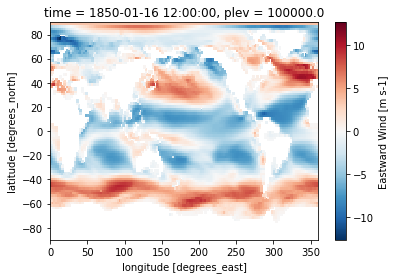

In [52]:
df7.ua[0,0].plot()

In [47]:
# put basic info in target directory

recipe.prepare_target()

ValueError: unable to decode time units 'hours since 0001-01-16 12:00:00.000000' with "calendar 'noleap'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [ ]:
# store first chunk
zgroup = zarr.open(target_dir.name)
print(zgroup.tree())

recipe.store_chunk(all_chunks[0])
zgroup[var].info

In [ ]:
# check first chunk
ds = xr.open_zarr(target_dir.name,decode_times=False)
ds[var][0].plot()